In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

In [2]:
import os
import cv2
import torch
import numpy as np
from tqdm import tqdm

from PIL import Image
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, models, transforms

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
    
device

device(type='cuda')

In [5]:
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2_vits14 = dinov2_vits14.to(device)

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


In [6]:
pca = PCA(n_components=3)
scaler = MinMaxScaler(clip=True)
patch_size = dinov2_vits14.patch_size

#520//14
patch_h  = 520//patch_size
patch_w  = 520//patch_size
feat_dim = 384 # vitl14

In [7]:
transform1 = transforms.Compose([
    transforms.Resize(520),
    transforms.CenterCrop(518), #should be multiple of model patch_size
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.2)
])

In [8]:
total_features  = []
ROOT_PATH = 'enter ur path'

folder_path = f'{ROOT_PATH}/train/ABBOTTS BABBLER/'
with torch.no_grad():
  list_img_path = os.listdir(folder_path)[0:4]
  for img_path in list_img_path:
    img_path = os.path.join(folder_path, img_path)
    img = Image.open(img_path).convert('RGB')
    img_t = transform1(img).to(device)
    
    features_dict = dinov2_vits14.forward_features(img_t.unsqueeze(0))
    features = features_dict['x_norm_patchtokens']
    total_features.append(features)

total_features = torch.cat(total_features, dim=0)
total_features.shape

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/chest-xray-pneumonia/chest_xray/train/train/ABBOTTS BABBLER/'

In [11]:
import glob
total_features = []
ROOT_PATH = '/kaggle/input/chest-xray-pneumonia/chest_xray'  # Set the base path to Kaggle's input directory

# Update the folder path to match the dataset structure and use glob to fetch all images
folder_path = os.path.join(ROOT_PATH, 'train')

# Using glob to get all images recursively matching the pattern
list_img_path = glob.glob(f'{folder_path}/**/*.jpeg', recursive=True)

with torch.no_grad():
    for img_path in list_img_path[0:4]:  # Limit to first 4 images
        img = Image.open(img_path).convert('RGB')
        img_t = transform1(img).to(device)

        # Forward pass to extract features
        features_dict = dinov2_vits14.forward_features(img_t.unsqueeze(0))
        features = features_dict['x_norm_patchtokens']
        total_features.append(features)

# Combine all extracted features
total_features = torch.cat(total_features, dim=0)

# Output the shape of the total features tensor
print(total_features.shape)

torch.Size([4, 1369, 384])


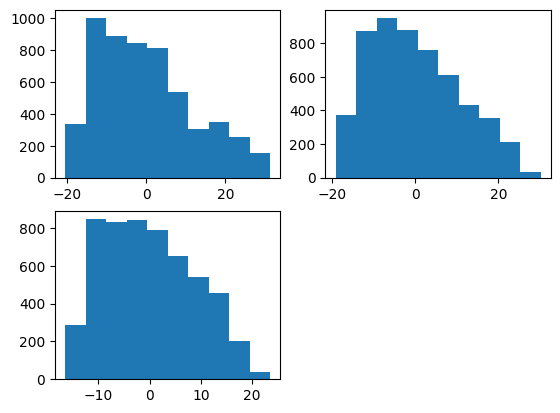

In [12]:
total_features = total_features.reshape(4 * patch_h * patch_w, feat_dim) #4(*H*w, 1024)
total_features = total_features.cpu()

pca = PCA(n_components=3)
pca.fit(total_features)
pca_features = pca.transform(total_features)

# visualize PCA components for finding a proper threshold
# 3 histograms for 3 components
plt.subplot(2, 2, 1)
plt.hist(pca_features[:, 0])
plt.subplot(2, 2, 2)
plt.hist(pca_features[:, 1])
plt.subplot(2, 2, 3)
plt.hist(pca_features[:, 2])
plt.show()
plt.close()

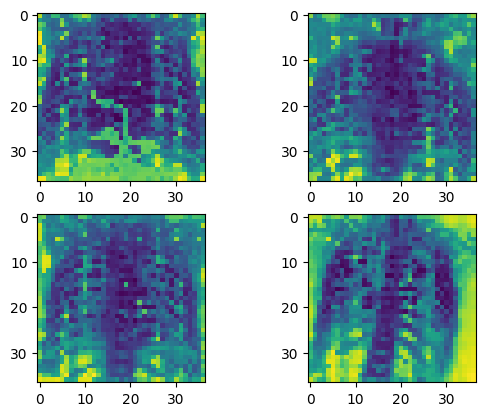

In [13]:
pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / \
                     (pca_features[:, 0].max() - pca_features[:, 0].min())
# pca_features = sklearn.processing.minmax_scale(pca_features)

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features[i*patch_h*patch_w : (i+1)*patch_h*patch_w, 0].reshape(patch_h, patch_w))

plt.show()

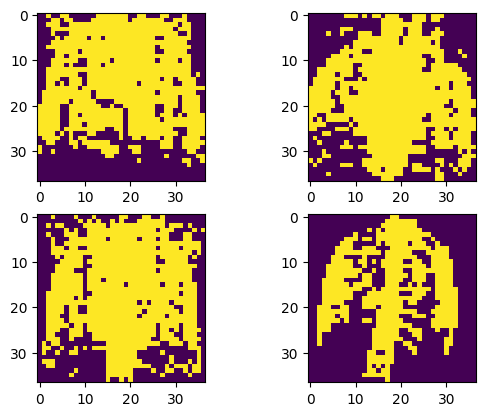

In [14]:
# segment/seperate the backgound and foreground using the first component
pca_features_bg = pca_features[:, 0] < 0.4 # from first histogram
pca_features_fg = ~pca_features_bg

# plot the pca_features_bg
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_bg[i * patch_h * patch_w: (i+1) * patch_h * patch_w].reshape(patch_h, patch_w))
plt.show()

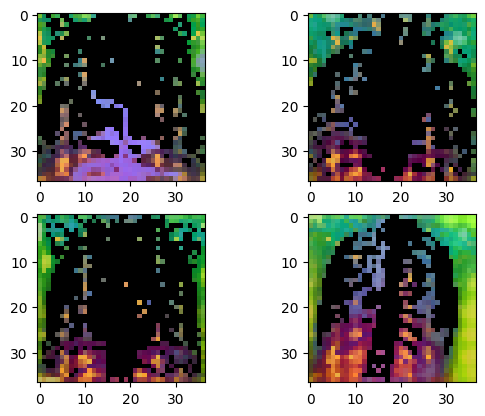

In [15]:
pca.fit(total_features[pca_features_fg]) 
pca_features_left = pca.transform(total_features[pca_features_fg])

for i in range(3):
    # min_max scaling
    pca_features_left[:, i] = (pca_features_left[:, i] - pca_features_left[:, i].min()) / (pca_features_left[:, i].max() - pca_features_left[:, i].min())

pca_features_rgb = pca_features.copy()
# for black background
pca_features_rgb[pca_features_bg] = 0
# new scaled foreground features
pca_features_rgb[pca_features_fg] = pca_features_left

# reshaping to numpy image format
pca_features_rgb = pca_features_rgb.reshape(4, patch_h, patch_w, 3)
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_rgb[i])

plt.show()

In [16]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
image_datasets = {
    x: datasets.ImageFolder(os.path.join(ROOT_PATH, x), data_transforms[x]) 
    for x in ['train', 'test']
}
image_datasets

In [17]:
ROOT_PATH = '/kaggle/input/chest-xray-pneumonia/chest_xray'

# Create the ImageFolder dataset for train and test
image_datasets = {
    x: datasets.ImageFolder(os.path.join(ROOT_PATH, x), data_transforms[x]) 
    for x in ['train', 'test']
}
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 5216
     Root location: /kaggle/input/chest-xray-pneumonia/chest_xray/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'test': Dataset ImageFolder
     Number of datapoints: 624
     Root location: /kaggle/input/chest-xray-pneumonia/chest_xray/test
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [18]:
batch_size = 8
num_workers = 4

data_loaders = {x: DataLoader(image_datasets[x], shuffle=True, batch_size=batch_size, num_workers=4)
    for x in ['train', 'test']
}

In [19]:
class_names = image_datasets['train'].classes
class_names

['NORMAL', 'PNEUMONIA']

In [20]:
class DinoVisionTransformerClassifier(nn.Module):
    def __init__(self):
        super(DinoVisionTransformerClassifier, self).__init__()
        self.transformer = dinov2_vits14
        self.classifier = nn.Sequential(
            nn.Linear(384, 256),
            nn.ReLU(),
            nn.Linear(256, len(class_names))
        )
    
    def forward(self, x):
        x = self.transformer(x)
        x = self.transformer.norm(x)
        x = self.classifier(x)
        return x
    
model = DinoVisionTransformerClassifier()
model = model.to(device)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.000001)

In [22]:
num_epoch = 10
for epoch in range(num_epoch):
    train_acc = 0
    train_loss = 0
    loop = tqdm(data_loaders['train'])
    for idx, (features, labels) in enumerate(loop):
        features = features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)

        predictions = outputs.argmax(dim=1, keepdim=True).squeeze()
        correct = (predictions == labels).sum().item()
        accuracy = correct / batch_size

        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch [{epoch}/{num_epoch}]")
        loop.set_postfix(loss=loss.item(), acc=accuracy)

Epoch [9/10]: 100%|██████████| 652/652 [00:53<00:00, 12.25it/s, acc=1, loss=0.0269]    


In [23]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
test_predicted = []
test_labels = []

with torch.no_grad():
    for features, labels in data_loaders["test"]:
        features = features.to(device)
        labels = labels.to(device)

        # calculate outputs by running images through the network
        outputs = model(features)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to(device) == labels).sum().item()
        
        test_labels += (labels.cpu().numpy().tolist())
        test_predicted += (predicted.cpu().numpy().tolist())

print(f'Accuracy of the network on the {len(data_loaders["test"])*6} test images: {100 * correct // total} %')

Accuracy of the network on the 468 test images: 91 %


In [24]:
print(classification_report(test_labels, test_predicted, target_names=class_names))

              precision    recall  f1-score   support

      NORMAL       0.99      0.79      0.88       234
   PNEUMONIA       0.89      1.00      0.94       390

    accuracy                           0.92       624
   macro avg       0.94      0.89      0.91       624
weighted avg       0.93      0.92      0.92       624



In [25]:
cm = confusion_matrix(test_labels, test_predicted)
df_cm = pd.DataFrame(
    cm, 
    index = class_names,
    columns = class_names
)
df_cm

,NORMAL,PNEUMONIA
NORMAL,184,50
PNEUMONIA,1,389


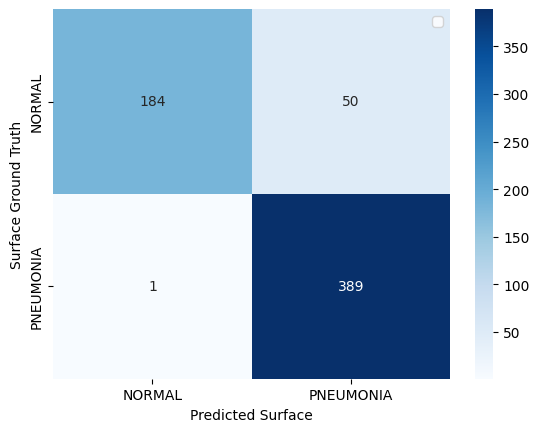

In [27]:

def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    plt.ylabel("Surface Ground Truth")
    plt.xlabel("Predicted Surface")
    plt.legend()
    
show_confusion_matrix(df_cm)